Current loop: 0

Next request at loop: -1



All done: 0

All accepted: 0

All rejected: 0

All cancelled: 0



Messages (0):


Process:

0: None. Done at loop: -1

1: None. Done at loop: -1

State 0: 0.014001400140014001 - 0.0028338522898226216, 0.011167547850191379
State 1: 0.041904190419041906 - 0.018892348598817478, 0.023011841820224428
State 2: 0.022602260226022602 - 0.06297449532939159, 0.040372235103368986
State 3: 0.1222122212221222 - 0.02623937305391317, 0.09597284816820903
State 4: 0.3852385238523852 - 0.0437322884231886, 0.3415062354291966
State 5: 0.414041404140414 - 0.021866144211594305, 0.3921752599288197
Max diff: 0.3921752599288197

Relative bandwidth: 0.585958595859586 - 0.9781338557884057, 0.39217525992881974
Absolute bandwidth: 0.00585958595859586 - 0.009781338557884057, 0.003921752599288197

Cancellations: 0.6947368421052632 - 0.052478746107826324, 0.6422580959974369

Average waiting queue length: 2.134813481348135 - 0.1793023825350733, 1.9555110988130617

Average w

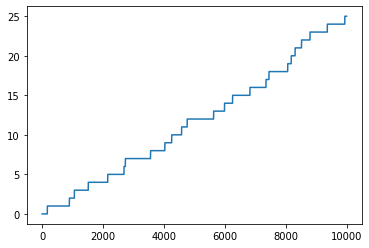

Done 10000


TypeError: can only concatenate tuple (not "float") to tuple

In [8]:
import numpy as np
import threading
import time
from queue import Queue
import sys
import matplotlib.pyplot as plt
import statistics as stat

import sympy as sp
from sympy.solvers.solveset import linsolve

waiting_queue = []
channels = []
all_accepted = 0
all_rejected = 0
all_done = 0
all_requests = 0
all_cancelled = 0

current_loop = 0
next_message_loop = -1


last_value = 0


def print_system_state():
    print("Current loop: {}\n".format(current_loop))
    print("Next request at loop: {}\n".format(next_message_loop))
    print("\n")

    print("All done: {}\n".format(all_done))
    print("All accepted: {}\n".format(all_accepted))
    print("All rejected: {}\n".format(all_rejected))
    print("All cancelled: {}\n".format(all_cancelled))

    print("\n")

    print("Messages ({}):\n".format(len(waiting_queue)))
    for val in list(waiting_queue).__reversed__():
        print("{} ".format(val))

    print("\nProcess:\n")
    for channel in channels:
        print("{}: {}. Done at loop: {}\n".format(channel.number, channel.value, channel.resume_on_loop))

def generate_next_exponential(lamb):
    bsv = np.random.uniform()
    return - 1 / lamb * np.log(1 - bsv)


class Channel():

    def __init__(self, number, on_accepted, on_rejected, on_done):
        self.number = number
        self.on_accepted = on_accepted
        self.on_rejected = on_rejected
        self.on_done = on_done
        self.accept_prob = accept_prob
        self.intensity = channel_intensity

        self.working = False
        self.resume_on_loop = -1
        self.value = None

    def should_accept(self, p):
        return np.random.choice([True, False], p=[p, 1 - p])

    def set_data(self, val):
        dist = generate_next_exponential(self.intensity)
        self.resume_on_loop = current_loop + dist
        self.working = True
        self.value = val

    def on_new_loop(self):
        if self.resume_on_loop != -1 and current_loop >= self.resume_on_loop:
            self.working = False
            self.resume_on_loop = -1
            val = self.value
            self.value = None

            accept = self.should_accept(self.accept_prob)
            if accept:
                self.on_accepted(self.number, val)
            else:
                self.on_rejected(self.number, val)

            self.on_done(self.number, val)


def on_channel_accept(number, val):
    global all_accepted
    all_accepted += 1

    request_live_end[val] = current_loop

def on_channel_reject(number, val):
    global all_rejected, all_cancelled
    all_rejected += 1

    rejected_count[val] = rejected_count.get(val, 0) + 1
    put_in_waiting_queue(val)

def on_channel_done(number, val):
    global all_done, waiting_queue
    all_done += 1

    refresh_channels()

def put_in_waiting_queue(val):
    global waiting_queue, all_cancelled
    if len(waiting_queue) == waiting_queue_limit:
        all_cancelled += 1
        if request_live_start.get(val, None) is not None:
            request_live_end[val] = current_loop
        return

    if request_live_start.get(val, None) is None:
        request_live_start[val] = current_loop

    request_in_queue_start[val] = current_loop + request_in_queue_start.get(val, 0)

    waiting_queue.append(val)
    return


def start_channels():
    running_channels = []

    for i in range(channel_count):
        channel = Channel(i, on_channel_accept, on_channel_reject, on_channel_done)
        running_channels.append(channel)

    return running_channels


def refresh_channels():
    global channels, waiting_queue

    for channel in channels:
        channel.on_new_loop()
        if not channel.working and len(waiting_queue) != 0:
            first = waiting_queue[0]
            waiting_queue = waiting_queue[1:]
            channel.set_data(first)
            request_in_queue_end[first] = current_loop + request_in_queue_end.get(first, 0)

def try_create_new_request():
    global current_loop, next_message_loop, last_value, all_requests

    if current_loop >= next_message_loop:
        last_value += 1
        all_requests += 1
        put_in_waiting_queue(last_value)

        diff = generate_next_exponential(request_intensity)
        next_message_loop = current_loop + diff


finish_state_count = []
finish_state_prob_in_time = []
requests_count_in_system_in_time = []
waiting_queue_len_in_time = []
working_channels_count_in_time = []
request_live_start = {}
request_live_end = {}
request_in_queue_start = {}
request_in_queue_end = {}
rejected_count = {}
unique_requests_in_time = []
accepted_count_in_time = []
prev_accepted = 0

def init_statistic():
    global waiting_queue_limit, finish_state_count, channel_count

    finish_state_count = [0 for i in range(channel_count + waiting_queue_limit + 1)]


def take_statistic():
    global finish_state_count, channels, waiting_queue, prev_accepted

    requests = 0
    working_channels_count = 0
    for channel in channels:
        if channel.working:
            requests += 1

    working_channels_count = requests
    requests += len(waiting_queue)

    finish_state_count[requests] += 1

    finish_state_prob = []
    for c in finish_state_count:
        finish_state_prob.append(c / sum(finish_state_count))
    finish_state_prob_in_time.append(finish_state_prob)

    requests_count_in_system_in_time.append(requests)
    waiting_queue_len_in_time.append(len(waiting_queue))
    working_channels_count_in_time.append(working_channels_count)

    unique_requests = 0
    for channel in channels:
        if rejected_count.get(channel.value, 0) == 0:
            unique_requests += 1
    for val in waiting_queue:
        if rejected_count.get(val, 0) == 0:
            unique_requests += 1
    unique_requests_in_time.append(unique_requests)

    accepted_count_in_time.append(all_accepted)

def make_finish_state_statistic(to_print):
    global finish_state_count, channel_count

    s = sum(finish_state_count)
    max_diff = 0
    practice_finish_state = []
    theor_finish_state = []
    for i in range(len(finish_state_count)):
        pract = finish_state_count[i] / s
        theor = get_finish_n_state_statistic(i)
        diff = np.abs(pract - theor)

        practice_finish_state.append(pract)
        theor_finish_state.append(theor)

        if diff > max_diff:
            max_diff = diff

        if to_print:
            print("State {}: {} - {}, {}".format(i, pract, theor, diff))

    if to_print:
        print("Max diff: {}".format(max_diff))

    return practice_finish_state, theor_finish_state, max_diff

def get_finish_n_state_statistic(i):
    return theor_state_prob[i]

    # changed_channel_intensity = channel_intensity * accept_prob
    # if i != channel_count + waiting_queue_limit:
    #     changed_channel_intensity *= accept_prob
    #
    # if i != channel_count * waiting_queue_limit - 1:
    #     changed_channel_intensity =
    #
    # if i > channel_count:
    #     theor = request_intensity ** i / (np.math.factorial(channel_count) * channel_count ** (i - channel_count) * changed_channel_intensity ** i)
    # else:
    #     theor = request_intensity ** i / (np.math.factorial(i) * changed_channel_intensity ** i)
    #
    # f = 0
    # for j in range(channel_count + 1):
    #     f += request_intensity ** j / (np.math.factorial(j) * changed_channel_intensity ** j)
    #
    # s = 0
    # for j in range(channel_count + 1, channel_count + waiting_queue_limit + 1):
    #     s += request_intensity ** j / (np.math.factorial(channel_count) * channel_count ** (j - channel_count) * changed_channel_intensity ** j)
    #
    # return theor / (f + s)


def make_bandwidth_statistic(pract_finish_state, theor_finish_state, to_print):
    print('')

    pract_relative_bandwidth = 1 - pract_finish_state[-1]
    theor_relative_bandwidth = 1 - theor_finish_state[-1]
    pract_absolute_bandwidth = request_intensity * pract_relative_bandwidth
    theor_absolute_bandwidth = request_intensity * theor_relative_bandwidth

    print('Relative bandwidth: {} - {}, {}'.format(pract_relative_bandwidth, theor_relative_bandwidth, abs(pract_relative_bandwidth - theor_relative_bandwidth)))
    print('Absolute bandwidth: {} - {}, {}'.format(pract_absolute_bandwidth, theor_absolute_bandwidth, abs(pract_absolute_bandwidth - theor_absolute_bandwidth)))


def make_cancellation_statistic():
    print('')

    pract_cancellations = all_cancelled / all_requests
    theor_cancellations = theor_state_prob[-1] + theor_state_prob[-2]*(1 - accept_prob)

    print("Cancellations: {} - {}, {}".format(pract_cancellations, theor_cancellations, abs(pract_cancellations - theor_cancellations)))


def make_average_waiting_queue_length(to_print):
    pract_average = stat.mean(waiting_queue_len_in_time)
    theor_average = 0
    for i in range(1, waiting_queue_limit + 1):
        theor_average += i * theor_state_prob[channel_count + i]

    if to_print:
        print('')
        print("Average waiting queue length: {} - {}, {}".format(pract_average, theor_average, abs(pract_average - theor_average)))
    return theor_average, pract_average

def make_average_working_channels_count(to_print):
    pract_average = stat.mean(working_channels_count_in_time)
    theor_average = 0
    for i in range(channel_count + 1):
        theor_average += i * theor_state_prob[i]
    for i in range(1, waiting_queue_limit + 1):
        theor_average += channel_count * theor_state_prob[channel_count + i]

    if to_print:
        print('')
        print("Average working channels count: {} - {}, {}".format(pract_average, theor_average, abs(pract_average - theor_average)))
    return theor_average

def make_average_requests_in_system_count(to_print, average_waiting, average_channels):
    pract_average = stat.mean(requests_count_in_system_in_time)
    theor_average = average_waiting + average_channels

    if to_print:
        print('')
        print("Average requests count in system: {} - {}, {}".format(pract_average, theor_average, abs(pract_average - theor_average)))
    return theor_average, pract_average

def make_average_request_live_in_system(to_print, average_request_system_count, average_request_system_count_pract):
    request_live_diff = []
    for val, start in request_live_start.items():
        request_live_diff.append(request_live_end[val] - start)

    pract_average = average_request_system_count_pract / request_intensity
    theor_average = average_request_system_count / (request_intensity)

    if to_print:
        print('')
        print("Average requests live time in system: {} - {}, {}".format(pract_average, theor_average,
                                                                 abs(pract_average - theor_average)))

    return pract_average


def make_average_request_live_in_queue(average_request_queue_count, average_request_queue_count_pract):
    print('')

    request_live_diff = []
    for val, start in request_in_queue_start.items():
        if request_in_queue_end.get(val, None) is not None:
            request_live_diff.append(request_in_queue_end[val] - start)

    pract_average = average_request_queue_count_pract / (request_intensity)
    theor_average = average_request_queue_count / (request_intensity)

    print("Average requests live time in queue: {} - {}, {}".format(pract_average, theor_average,
                                                                 abs(pract_average - theor_average)))


def make_average_uniqe_requests(average_request_system_count):
    print('')

    pract_average = stat.mean(unique_requests_in_time)
    theor_average = average_request_system_count * accept_prob

    print("Average uniqe requests in system: {} - {}, {}".format(pract_average, theor_average,
                                                                 abs(pract_average - theor_average)))


def reset():
    global waiting_queue, channels, all_accepted, all_rejected, all_done, all_cancelled, current_loop, next_message_loop
    global finish_state_count, finish_state_prob_in_time, requests_count_in_system_in_time, waiting_queue_len_in_time
    global working_channels_count_in_time, request_live_start, request_live_end, request_in_queue_start
    global request_in_queue_end, rejected_count, unique_requests_in_time, accepted_count_in_time

    waiting_queue = []
    channels = []
    all_accepted = 0
    all_rejected = 0
    all_done = 0
    all_cancelled = 0
    current_loop = 0
    next_message_loop = -1

    finish_state_count = []
    finish_state_prob_in_time = []
    requests_count_in_system_in_time = []
    waiting_queue_len_in_time = []
    working_channels_count_in_time = []
    request_live_start = {}
    request_live_end = {}
    request_in_queue_start = {}
    request_in_queue_end = {}
    rejected_count = {}
    unique_requests_in_time = []
    accepted_count_in_time = []

def run(loop_limit, to_print=True, finish_state_statistic_only=False, system_live_time_only=False):
    global channels, current_loop, next_message_loop

    reset()

    init_statistic()
    channels = start_channels()

    if to_print:
        print_system_state()

    diff = generate_next_exponential(request_intensity)
    next_message_loop = current_loop + diff

    while True:
        current_loop += 1
        if current_loop == loop_limit:
            break

        refresh_channels()

        take_statistic()

        try_create_new_request()

        #print_system_state()
        #time.sleep(1)


    for val in waiting_queue:
        request_live_end[val] = current_loop
        request_in_queue_end[val] = current_loop + request_in_queue_end.get(val, 0)

    for channel in channels:
        if channel.working:
            request_live_end[channel.value] = current_loop

    if finish_state_statistic_only:
        return make_finish_state_statistic(to_print)

    if system_live_time_only:
        average_waiting = make_average_waiting_queue_length(to_print)
        average_channels = make_average_working_channels_count(to_print)
        average_system, average_system_pract = make_average_requests_in_system_count(to_print, average_waiting, average_channels)
        return make_average_request_live_in_system(to_print, average_system, average_system_pract)

    pract_finish_state, theor_finish_state, max_diff = make_finish_state_statistic(to_print)
    make_bandwidth_statistic(pract_finish_state, theor_finish_state, to_print)
    make_cancellation_statistic()
    average_waiting, average_waiting_pract = make_average_waiting_queue_length(to_print)
    average_channels = make_average_working_channels_count(to_print)
    average_system, average_system_pract = make_average_requests_in_system_count(to_print, average_waiting, average_channels)
    make_average_request_live_in_system(to_print, average_system, average_system_pract)
    make_average_request_live_in_queue(average_waiting, average_waiting_pract)


def run_max_diff_finish_state_test():
    x_array = range(100)
    y_array = []
    for x in x_array:
        y_array.append(run(loop_limit=10000, to_print=False, finish_state_statistic_only=True)[2])

    plt.plot(x_array, y_array)
    plt.show()


def run_live_time_test():
    x_array = range(10000, 150000, 10000)
    y_array = []
    for x in x_array:
        print('Done', x)
        y_array.append(run(loop_limit=x, to_print=False, system_live_time_only=True))

    plt.plot(x_array, y_array)
    plt.show()

def show_stationary(states = None):
    x = range(len(finish_state_prob_in_time))
    if states is None:
        states = range(len(finish_state_prob_in_time[0]))
    for state in states:
        y = []
        ty = []
        for t in range(len(finish_state_prob_in_time)):
            y.append(finish_state_prob_in_time[t][state])
            ty.append(theor_state_prob[state])
        plt.plot(x, y)
        plt.plot(x, ty)
    plt.show()

def run_max_diff_finish_state_to_loop_limit_test():
    x_array = range(100, 1000, 100)
    y_array = []
    for x in x_array:
        test = []
        for i in range(100):
            test.append(run(loop_limit=x, to_print=False, finish_state_statistic_only=True)[2])
        y_array.append(stat.mean(test))

    plt.plot(x_array, y_array)
    plt.show()


def solve_theor_states_prob(with_addition=True):
    symbols = [sp.Symbol('p' + str(i)) for i in range(channel_count + waiting_queue_limit + 1)]

    system = []
    system.append(-request_intensity * symbols[0] + accept_prob * channel_intensity * symbols[1])
    for i in range(1, channel_count):
        system.append(
            request_intensity * symbols[i - 1] - (request_intensity + i * accept_prob * channel_intensity) * symbols[
                i] + (i + 1) * accept_prob * channel_intensity * symbols[i + 1])
    for i in range(channel_count, channel_count + waiting_queue_limit - 1):
        system.append(
            request_intensity * symbols[i - 1] - (request_intensity + channel_count * accept_prob * channel_intensity) *
            symbols[i] + channel_count * accept_prob * channel_intensity * symbols[i + 1])

    system.append(
        request_intensity * symbols[-3] - (request_intensity + channel_count * accept_prob * channel_intensity) *
        symbols[-2] + channel_count * channel_intensity * symbols[-1])

    if with_addition:
        system.append(request_intensity * symbols[-2] - channel_count * channel_intensity * symbols[-1])

    last = symbols[0]
    for i in range(1, channel_count + waiting_queue_limit + 1):
        last += symbols[i]
    last -= 1
    system.append(last)

    print(system)

    res = list(linsolve(system, *symbols))
    if len(res) == 0 and with_addition:
        return solve_theor_states_prob(False)
    return list(res[0])


def calculate_theor_states_prob():
    theor_state_prob = [0] * (channel_count + waiting_queue_limit + 1)

    if accept_prob == 0:
        theor_state_prob[-2] = channel_count * channel_intensity / (channel_count * channel_intensity + request_intensity)
        theor_state_prob[-1] = 1 - theor_state_prob[-2]
    else:
        first_sum = 0
        for i in range(channel_count + 1):
            first_sum += request_intensity ** i / (np.math.factorial(i) * (channel_intensity * accept_prob) ** i)
        second_sum = 0
        for i in range(channel_count + 1, channel_count + waiting_queue_limit):
            second_sum += request_intensity ** i / (np.math.factorial(channel_count) * channel_count ** (i - channel_count) * (channel_intensity * accept_prob) ** i)
        res_sum = first_sum + second_sum + request_intensity ** (channel_count + waiting_queue_limit) / (np.math.factorial(channel_count) * channel_count ** waiting_queue_limit * channel_intensity ** (channel_count + waiting_queue_limit))

        theor_state_prob[0] = 1 / res_sum
        for i in range(1, channel_count + 1):
            theor_state_prob[i] = request_intensity ** i / (np.math.factorial(i) * (channel_intensity * accept_prob) ** i) * theor_state_prob[0]

        for i in range(channel_count + 1, channel_count + waiting_queue_limit):
            theor_state_prob[i] = request_intensity ** i / (np.math.factorial(channel_count) * channel_count ** (i - channel_count) * (request_intensity * accept_prob) ** i) * theor_state_prob[0]

        theor_state_prob[channel_count + waiting_queue_limit] = request_intensity ** (channel_count + waiting_queue_limit) / (np.math.factorial(channel_count) * channel_count ** waiting_queue_limit * request_intensity ** (channel_count + waiting_queue_limit) * accept_prob ** (channel_count + waiting_queue_limit - 1)) * theor_state_prob[0]

    return theor_state_prob

request_intensity = 0.01
channel_intensity = 0.005
channel_count = 2
waiting_queue_limit = 3
accept_prob = 0.3

theor_state_prob = calculate_theor_states_prob()
run(10000)

plt.plot(range(len(accepted_count_in_time)), accepted_count_in_time)

plt.show()

run_live_time_test()

show_stationary()